[Notebook Owners &lt;](3_Owners.ipynb) | [&gt; Collaboration](5_Collaboration.ipynb)

# How are notebooks organized?

To look into variables, functions, and imports, I used python abstract syntax tree. Only 86.25% of Python 3 notebooks were able to be fully parsed by the ast package. The remaining could have failed due to a syntax error in the users code or because of a parsing problem with strings being held in json files.

## Results Summary:
- The median number of cells per notebook is 19.0 (average 28.71)
- 3.97% of notebooks have no code. Among notebooks with code, there is an average of 145.7 lines of code per notebook. The median is 86 lines. The most is 462,118 lines.
- 22.77% of notebooks have no markdown text. Among notebooks with markdown, the average is 550.87 words of text. The median is 194. The notebook with the most markdown has 200,404 words of markdown.
- Markdown is more likely to occur at the very beginning of a notebook (53% of cells in the first 5% of a given notebook) than it is to occur towards the end (26% of cells in the last 5% of a given notebook).
- Execution order:
    - 25% of notebooks have cells run out of order.
    - 84% of notebooks have at least one displayed result.
    - 29% of notebooks with at least one displayed result have cells run out of order.
    - 27.19% of notebooks with at least one displayed result have cells run out of order.
- Variables
    - 2.72% of notebooks that could be parsed had variables used before they were defined.
    - Of these, there are an average of 1.51 variables used before they were defined.
    - Within notebooks that could be parsed, there are on average 6.38 variables defined that are never used.
- Functions
    - 5.54% of notebooks that could be parsed had functions used before they were defined.
    - Of these, there are an average of 2.01 functions used before they were defined.
    - Within notebooks that could be parsed, there are on average 1.6 functions defined that are never used.
    - **Among notebooks that have at least one user defined function**
        - 12.53% of notebooks that could be parsed and have at least one user defined function had functions used before they were defined.
- Imports
    - 1.21% of notebooks that could be parsed had packages used before they were imported.
    - Of these, there are an average of 1.28 packages used before they were imported.
    - Within notebooks that could be parsed, there are on average 3.99 packages imported that are never used.
    - **Among notebooks that have at least one import**
        -  1.57% of notebooks that could be parsed and had at least one import had packages used before they were imported.
- Output
    - 84.03% of notebooks have at least one output.
    - 68.34% of notebooks have at least one stream output.
    - 44.73% of notebooks have at least one display output.
    - 59.26% of notebooks have at least one execution output.
- Repo Descriptions
    - 54.13% of repositories have descriptions
    - The most commonly used words in readmes and repo descriptions are: data, learning, project, python, using, machine, analysis, code, repository, and deep.

---

# Import Packages and Load Data

In [1]:
import load_data
import datetime
import pandas as pd
import numpy as np
import math
import pickle
from io import BytesIO, StringIO
import matplotlib.pyplot as plt
import ast
import scipy
import re
from collections import deque
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))


Load dataframes

In [2]:
notebooks = load_data.load_notebooks()
repos = load_data.load_repos()

Notebooks loaded in 0:00:30.149199
Repos loaded in 0:00:04.110168


Load aggregated dataframes. Code used to create cell types, cell order, cell stats, output, and statuses is in [aggregate.py](aggregate.py).

In [3]:
cell_types_df = load_data.load_cell_types()
cell_order_df = load_data.load_cell_order()
cell_stats_df = load_data.load_cell_stats()
statuses_df = load_data.load_statuses()
output_df = load_data.load_output()

Cell types loaded in 0:00:01.890610
Cell order loaded in 0:00:43.181705
Cell stats loaded in 0:00:01.896449
Statuses loaded in 0:00:02.040861
Outputs loaded in 0:00:05.719131


In [4]:
notebooks_py3 = notebooks[(notebooks.lang_name == 'python')&([str(n).startswith('3') for n in notebooks.lang_version])]
notebooks_py3 = notebooks_py3.merge(statuses_df[['file','syntax']], on = 'file')
print("{0}% of Python 3 notebooks were able to be parsed with the Python Abstract Syntax Tree".format(
    round(100*sum(notebooks_py3.syntax)/len(notebooks_py3), 2)
))

86.25% of Python 3 notebooks were able to be parsed with the Python Abstract Syntax Tree


---

# Manipulate Data

### Cells, lines of code, and words of markdown per notebook

In [5]:
# 15 seconds
# Look at notebooks with at least one non-empty cell
start = datetime.datetime.now()

nbs_w_cells = set(cell_stats_df[np.logical_or(
            cell_stats_df.lines_of_code != 0,
            cell_stats_df.num_words != 0
        )].file.unique())

cell_stats_w_cells_df = cell_stats_df[cell_stats_df.file.isin(nbs_w_cells)]

notebooks = notebooks[notebooks.file.isin(nbs_w_cells)]

end = datetime.datetime.now()
print(end - start)

0:00:16.138132


### Markdown to Code distribution throughout the notebook

In [6]:
def get_distribution(round_dec = 1):

    def get_type(t):
        if t in ['markdown','heading',
                 'markdownn','moarkdown'
        ]:
            return 'markdown'
        elif t == 'interactivecode' or str(t).startswith('code'):
            return 'code'
        else:
            return None
    
    distribution = {
        'type': [],
        'place': [],
        'count': []
    }
    
    count = 0
    for order in cell_order_df.cell_type:
        if len(order) > 1:
            for i in range(len(order)):
                cell_type = get_type(order[i])
                if cell_type != None:
                    placement = round(i / (len(order)-1),round_dec)
                    distribution['type'].append(cell_type)
                    distribution['place'].append(placement)
                    distribution['count'].append(count)
                    count += 1
           
    return pd.DataFrame(distribution)

#### Distribution with quantile rounded to the 10s place

In [7]:
# about 6 minutes
start = datetime.datetime.now()

distribution = get_distribution()
distribution_counts = distribution.groupby(
    ['place','type']
)['count'].sum().reset_index()
distribution_total = distribution_counts.groupby(
        'place'
    )['count'].sum().reset_index().rename(
        columns={'count':'total'}
)
distribution_df = distribution_counts.merge(distribution_total, on = 'place')
distribution_df['prop'] = distribution_df['count'] / distribution_df['total']

end = datetime.datetime.now()
print(end - start)

0:05:09.617156


---

# Visualizations & Statistics

## Cells, lines of code, and words of markdown per notebook

In [8]:
med = cell_stats_df.num_cells.median()
mean = cell_stats_df.num_cells.mean()

print("The median number of cells per notebook is {0}. The average number of cells per notebooks is {1}.".format(
    med, round(mean,2)
))

The median number of cells per notebook is 19.0. The average number of cells per notebooks is 28.71.


In [9]:
prop_0 = sum(cell_stats_df.lines_of_code == 0)/len(cell_stats_df)
med = cell_stats_df[cell_stats_df.lines_of_code > 0].lines_of_code.median()
mean = cell_stats_df[cell_stats_df.lines_of_code > 0].lines_of_code.mean()
mx = cell_stats_df.lines_of_code.max()

print("{0}% of notebooks have no code. Among notebooks with code, there is an average of {1} lines of code per notebook. The median is {2} lines. The most is {3:,} lines.".format(
    round(100*prop_0, 2),  round(mean, 2), int(med), int(mx)
))

3.97% of notebooks have no code. Among notebooks with code, there is an average of 145.67 lines of code per notebook. The median is 86 lines. The most is 462,118 lines.


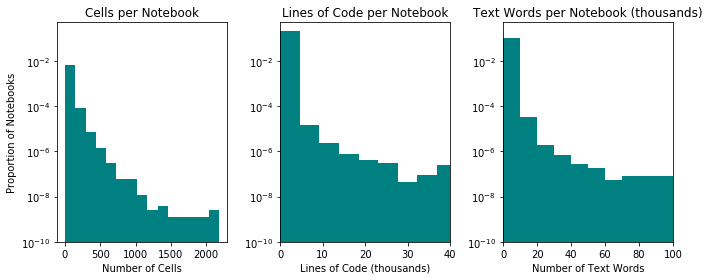

In [10]:
fig = plt.figure(figsize = (10, 4))
plt.subplot(1,3,1)
plt.hist(cell_stats_df['num_cells'], density = True, bins = 15, color = 'teal')
plt.xlabel('Number of Cells')
plt.ylabel('Proportion of Notebooks')
plt.yscale('log')
plt.ylim(10**-10, 0.5)
plt.title('Cells per Notebook')

plt.subplot(1,3,2)
plt.hist(cell_stats_df[cell_stats_df.lines_of_code>0].lines_of_code/1000, density = True, bins = 100, color = 'teal')
plt.title('Lines of Code per Notebook')
plt.xlabel('Lines of Code (thousands)')
plt.xlim(0, 40)
plt.yscale('log')
plt.ylim(10**-10, 0.5)

plt.subplot(1,3,3)
plt.hist(cell_stats_df[cell_stats_df.num_words>0].num_words/1000, density = True, bins = 20, color = 'teal')
plt.title('Text Words per Notebook (thousands)')
plt.xlabel('Number of Text Words')
plt.xlim(0, 100)
plt.yscale('log')
plt.ylim(10**-10, 0.5)

plt.tight_layout()
plt.show()

In [11]:
num_0 = sum(cell_stats_df.num_words == 0)/len(cell_stats_df)
med = cell_stats_df[cell_stats_df.num_words > 0].num_words.median()
mean = cell_stats_df[cell_stats_df.num_words > 0].num_words.mean()
mx = cell_stats_df.num_words.max()

print("{0}% of notebooks have no markdown text. Among notebooks with markdown, the average is {1} words of text. The median is {2}. The notebook with the most markdown has {3:,} words of markdown and can be found at {4}.".format(
    round(100*num_0, 2), round(mean, 2), int(med), int(mx),
    notebooks[notebooks.file == cell_stats_df[cell_stats_df.num_words == mx].file.values[0]].html_url.values[0]
))

27.77% of notebooks have no markdown text. Among notebooks with markdown, the average is 550.87 words of text. The median is 194. The notebook with the most markdown has 200,404 words of markdown and can be found at https://github.com/jordanplanders/Thinkful/blob/367bcd6908fd3a96f4ec039f95a82f917e36e54e/Bootcamp/Unit%206/big-data-student-resources/Twitter%20streaming%20challenge.ipynb.


## Distribution of code vs markdown cells across the notebook

In [12]:
prop_have_markdown = sum(['markdown' in c for c in cell_order_df.cell_type])/len(cell_order_df)
prop_have_code = sum(['code' in c for c in cell_order_df.cell_type])/len(cell_order_df)
prop_have_none = sum(['markdown' not in c and 'code' not in c for c in cell_order_df.cell_type])/len(cell_order_df)

print("{0}% of notebooks have at least one non-empty markdown cell.".format(round(100*prop_have_markdown, 2)))
print("{0}% of notebooks have at least one non-empty code cell.".format(round(100*prop_have_code, 2)))
print("{0}% of notebooks have no cells or all empty cells.".format(round(100*prop_have_none, 2)))


71.75% of notebooks have at least one non-empty markdown cell.
97.88% of notebooks have at least one non-empty code cell.
0.03% of notebooks have no cells or all empty cells.


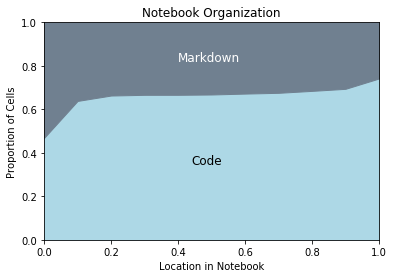

In [13]:
distribution_df_code = distribution_df[distribution_df.type == 'code']
plt.fill_between(
    distribution_df_code.place,
    0,
    distribution_df_code.prop,
    color='lightblue'
)
plt.fill_between(
    distribution_df_code.place,
    distribution_df_code.prop,
    1,
    color='slategrey'
)

plt.text(0.4, 0.82, 'Markdown', color = 'white', fontsize = 12)
plt.text(0.44, 0.35, 'Code', fontsize = 12)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.xlabel('Location in Notebook')
plt.ylabel('Proportion of Cells')
plt.title('Notebook Organization')
plt.show()

In [14]:
print("Markdown is more likely to occur at the very beginning of a notebook ({0}% of cells in the first 5% of a given notebook) than it is to occur towards the end ({1}% of cells in the last 5% of a given notebook).".format(
    round(100 - 100*distribution_df_code.prop[0], 2), 
    round(100 - 100*distribution_df_code.prop.iloc[-1], 2)
))

Markdown is more likely to occur at the very beginning of a notebook (53.12% of cells in the first 5% of a given notebook) than it is to occur towards the end (25.82% of cells in the last 5% of a given notebook).


## Execution order

In [15]:
counts = pd.Series(cell_order_df.in_order).value_counts()
prop_out_order = counts[False] / (counts[False] + counts[True])
print("{0}% of all notebooks have cells run out of order.".format(round(100*prop_out_order, 2)))

output_df['num_display'] = (output_df.num_execute_result + 
                            output_df.num_display_data + 
                            output_df.num_stream)

prop_has_display = sum(output_df['num_display'] > 0) / len(output_df)
print("\n{0}% of notebooks have at least one displayed output.".format(round(100*prop_has_display, 2)))

cell_order_df_has_display = cell_order_df[cell_order_df.file.isin(
    output_df[output_df['num_display'] > 0].file
)]
counts_has_display = pd.Series(cell_order_df_has_display.in_order).value_counts()
prop_out_order_has_display = counts_has_display[False] / (counts_has_display[False] + counts_has_display[True])
print("{0}% of notebooks with at least one displayed output have cells run out of order.".format(
    round(100*prop_out_order_has_display, 2)
))

25.04% of all notebooks have cells run out of order.

84.03% of notebooks have at least one displayed output.
29.49% of notebooks with at least one displayed output have cells run out of order.


## *Definition* Order

In [16]:
statuses_good_df = statuses_df[statuses_df.syntax]
print('{0}% of Python 3 notebooks had code that was able to be parsed with the python abstract syntax tree (ast) package.'.format(
    round(100*len(statuses_good_df)/len(statuses_df),2)
))

86.25% of Python 3 notebooks had code that was able to be parsed with the python abstract syntax tree (ast) package.


In [17]:
print('Variables')
print('{0}% of notebooks that could be parsed had variables used before they were defined.'.format(
    round(100*sum(statuses_good_df['variable'] > 0) / len(statuses_df), 2)
))
print('Of these, there are an average of {0} variables used before they were defined.'.format(
    round(statuses_good_df[statuses_good_df['variable'] > 0]['variable'].mean(), 2)
))
print('Within notebooks that could be parsed, there are on average {0} variables defined that are never used.'.format(
    round(statuses_good_df['variables_not_used'].mean(), 2)
))

print('\nFunctions')
print('{0}% of notebooks that could be parsed had functions used before they were defined.'.format(
    round(100*sum(statuses_good_df['function'] > 0) / len(statuses_df),2)
))
print('Of these, there are an average of {0} functions used before they were defined.'.format(
    round(statuses_good_df[statuses_good_df['function'] > 0]['function'].mean(), 2)
))
print('Within notebooks that could be parsed, there are on average {0} functions defined that are never used.'.format(
    round(statuses_good_df['functions_not_used'].mean(), 2)
))

print('\nImports')
print('{0}% of notebooks that could be parsed had packages used before they were imported.'.format(
    round(100*sum(statuses_good_df['import'] > 0) / len(statuses_df),2)
))
print('Of these, there are an average of {0} packages used before they were imported.'.format(
    round(statuses_good_df[statuses_good_df['import'] > 0]['import'].mean(), 2)
))
print('Within notebooks that could be parsed, there are on average {0} packages imported that are never used.'.format(
    round(statuses_good_df['imports_not_used'].mean(), 2)
))

print('\n{0}% of notebooks that could be parsed had at least one of these issues.'.format(
    round(100*sum(np.logical_or(
                    np.logical_or(
                        statuses_good_df['import'] > 0,
                        statuses_good_df['function'] > 0
                    ),
                    statuses_good_df['variable'] > 0
            )) / len(statuses_df), 
    2
)))

Variables
2.72% of notebooks that could be parsed had variables used before they were defined.
Of these, there are an average of 1.51 variables used before they were defined.
Within notebooks that could be parsed, there are on average 6.38 variables defined that are never used.

Functions
5.54% of notebooks that could be parsed had functions used before they were defined.
Of these, there are an average of 2.01 functions used before they were defined.
Within notebooks that could be parsed, there are on average 1.6 functions defined that are never used.

Imports
1.21% of notebooks that could be parsed had packages used before they were imported.
Of these, there are an average of 1.28 packages used before they were imported.
Within notebooks that could be parsed, there are on average 3.99 packages imported that are never used.

8.8% of notebooks that could be parsed had at least one of these issues.


Look at function definition order within notebooks with at least one user defined function

In [18]:
f = open('analysis_data/function_defs.df', 'rb')
function_defs_df = pickle.load(f)
f.close()

In [19]:
function_defs_df.head()

,file,function,parameters
0,0-c00l..Applied-Data-Science..Applied Plotttin...,onclick,1
1,0-c00l..Applied-Data-Science..Intro to DS..Ass...,answer_one,0
2,0-c00l..Applied-Data-Science..Intro to DS..Ass...,answer_two,0
3,0-c00l..Applied-Data-Science..Intro to DS..Ass...,answer_three,0
4,0-c00l..Applied-Data-Science..Intro to DS..Ass...,answer_four,0


In [20]:
statuses_good_w_func_df = statuses_good_df[statuses_good_df.file.isin(function_defs_df.file)]
print('{0}% of notebooks that could be parsed and have at least one user defined function had functions used before they were defined.'.format(
    round(100*sum(statuses_good_w_func_df['function'] > 0) / len(statuses_good_w_func_df),2)
))
print('Of these, there are an average of {0} functions used before they were defined.'.format(
    round(statuses_good_w_func_df[statuses_good_w_func_df['function'] > 0]['function'].mean(), 2)
))
print('Within notebooks that could be parsed and have at lest one user defined function , there are on average {0} functions defined that are never used.'.format(
    round(statuses_good_w_func_df['functions_not_used'].mean(), 2)
))

12.53% of notebooks that could be parsed and have at least one user defined function had functions used before they were defined.
Of these, there are an average of 1.99 functions used before they were defined.
Within notebooks that could be parsed and have at lest one user defined function , there are on average 3.16 functions defined that are never used.


Look at import use order within notebooks with at least one import

In [21]:
start = datetime.datetime.now()

f = open('analysis_data/nb_imports.df','rb')
nb_imports_df = pickle.load(f)
f.close()

end = datetime.datetime.now()
print(end - start)

0:00:54.439687


In [22]:
nb_imports_w_import_df = nb_imports_df[[len(im) > 0 for im in nb_imports_df.imports]]
statuses_good_w_import_df = statuses_good_df[statuses_good_df.file.isin(nb_imports_w_import_df.file)]

print('{0}% of notebooks that could be parsed and had at least one import had packages used before they were imported.'.format(
    round(100*sum(statuses_good_w_import_df['import'] > 0) / len(statuses_good_w_import_df),2)
))
print('Of these, there are an average of {0} packages used before they were imported.'.format(
    round(statuses_good_w_import_df[statuses_good_w_import_df['import'] > 0]['import'].mean(), 2)
))
print('Within notebooks that could be parsed and had at least one import, there are on average {0} packages imported that are never used.'.format(
    round(statuses_good_w_import_df['imports_not_used'].mean(), 2)
))

1.57% of notebooks that could be parsed and had at least one import had packages used before they were imported.
Of these, there are an average of 1.28 packages used before they were imported.
Within notebooks that could be parsed and had at least one import, there are on average 4.46 packages imported that are never used.


## Output

In [23]:
prop_at_least_one = sum(
    np.logical_or(
        np.logical_or(
            output_df.num_execute_result > 0, 
            output_df.num_display_data > 0
        ), 
        output_df.num_stream > 0
    )
)/len(output_df)
print("{0}% of notebooks have at least one output.".format(round(100*prop_at_least_one, 2)))
print("\nBreakdown:")

prop_stream = sum(output_df.num_stream > 0)/len(output_df)
print("{0}% of notebooks have at least one stream output.".format(round(100*prop_stream, 2)))

prop_display = sum(output_df.num_display_data > 0)/len(output_df)
print("{0}% of notebooks have at least one display output.".format(round(100*prop_display, 2)))

prop_execute = sum(output_df.num_execute_result > 0)/len(output_df)
print("{0}% of notebooks have at least one execution output.".format(round(100*prop_execute, 2)))

84.03% of notebooks have at least one output.

Breakdown:
68.34% of notebooks have at least one stream output.
44.73% of notebooks have at least one display output.
59.26% of notebooks have at least one execution output.


## Repo Descriptions

In [24]:
prop_has_desc = sum(~repos.repo_description.isna())/len(repos)

print("{0}% of repositories have descriptions.".format(
    round(100*prop_has_desc, 2)
))

54.13% of repositories have descriptions.


In [25]:
repos['processed_content'] = [
    re.sub('[^a-zA-Z]',' ',str(c)).replace('\\n',' ').replace('#','').replace('`','').lower().split()
    for c in repos.repo_description.fillna('')
]
repo_words = [w for w in 
         load_data.flatten(repos.processed_content)
    if (w.lower() not in stop and
        len(w) > 1 and 
        not (w.startswith('x') and len(w) < 4))]

In [26]:
print("The most commonly used words in readmes and repo descriptions are: {0}.".format(
    ', '.join(pd.Series(repo_words).value_counts().index[:9]) 
        + ', and ' 
        + pd.Series(repo_words).value_counts().index[10]
))

The most commonly used words in readmes and repo descriptions are: data, learning, project, python, using, machine, analysis, code, repository, and deep.


[Notebook Owners &lt;](3_Owners.ipynb) | [&gt; Collaboration](5_Collaboration.ipynb)